### Histopathologic Cancer Detection

The Histopathologic Cancer Detection competition on Kaggle is a binary image classification challenge where participants are tasked with identifying metastatic cancer in small image patches extracted from larger digital pathology scans. The images are derived from lymph node sections and are presented as 32x32 pixel patches. Each image is labeled as either cancerous (label = 1) or non-cancerous (label = 0).

The primary objective of this competition is to develop a machine learning model capable of accurately detecting the presence of metastatic cancer in these small image patches. Early and accurate detection of cancer is critical for effective treatment, making this task highly significant in the medical domain.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict
from collections import OrderedDict
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import io

### EDA


In [2]:
# Load the dataset
df1 = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df1.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
df1['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

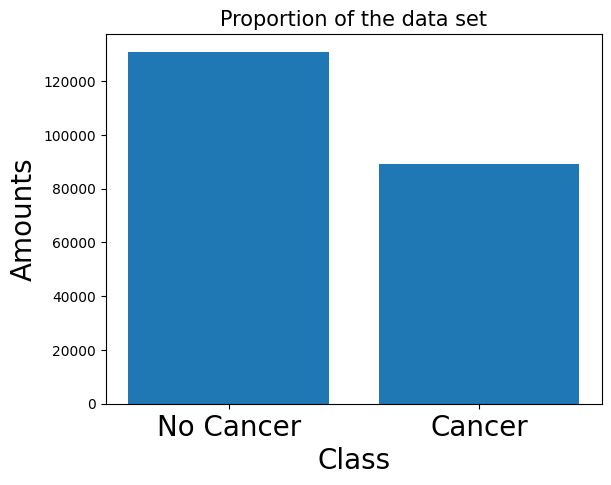

In [4]:
# Data exploration - Visualizing class distribution
ax = plt.subplots()
y = df1['label'].value_counts()
labels = ['No Cancer', 'Cancer']

plt.xticks(range(len(y)), labels, fontsize=20)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Amounts', fontsize=20)
plt.title('Proportion of the data set', fontsize=15)
plt.bar(range(len(y)), y)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 9.0

plt.show()


The graph shows a clear class imbalance, with the "No Cancer" class being more prevalent than the "Cancer" class.  Understanding the class distribution is crucial in tasks like cancer detection because it may necessitate the use of techniques to handle class imbalance, such as:

* Data Augmentation: Increasing the number of "Cancer" samples through data augmentation techniques.
* Re-sampling: Over-sampling the minority class or under-sampling the majority class.
* Use of specialized loss functions: Such as weighted cross-entropy loss, to penalize the model more for misclassifying the minority class.

### Data Pre-processing

In [5]:
# Prepare the dataset for image processing
# 1. Add 'image_path' column to the DataFrame
df1['image_path'] = df1['id'].apply(
    lambda row: '/kaggle/input/histopathologic-cancer-detection/train/' + row + '.tif'
)

# 2. Choose 10,000 data points from the dataset
df1 = df1.sample(10_000)

# 3. Duplicate 'image_path' column to 'image' and drop 'id' column
df1['image'] = df1['image_path']
df1 = df1.drop(columns=['id'])

# 4. Rename 'label' column to 'labels'
df1 = df1.rename(columns={'label': 'labels'})

# 5. Create a dataset from the DataFrame
dataset = Dataset.from_pandas(df1)

# 6. Resize images to 224x224 pixels
IMAGE_SIZE = (224, 224)

def load_and_resize_images(examples):
    resized_images = []
    for image_path in examples["image_path"]:
        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize(IMAGE_SIZE)
            resized_images.append(img)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            resized_images.append(None)  # Handle the error by appending None or an alternative image
    examples["image"] = resized_images
    return examples

# Apply the load and resize function to the dataset in batches
dataset = dataset.map(load_and_resize_images, batched=True, batch_size=8)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
# Split the dataset into training, validation, and test sets
train1, eval1 = train_test_split(dataset, test_size=0.2)
test1, eval1 = train_test_split(Dataset.from_dict(eval1), test_size=0.5)

# Create a DatasetDict for use with PyTorch
ds = DatasetDict({'train': Dataset.from_dict(train1), 
                 'eval': Dataset.from_dict(eval1),
                 'test': Dataset.from_dict(test1)})

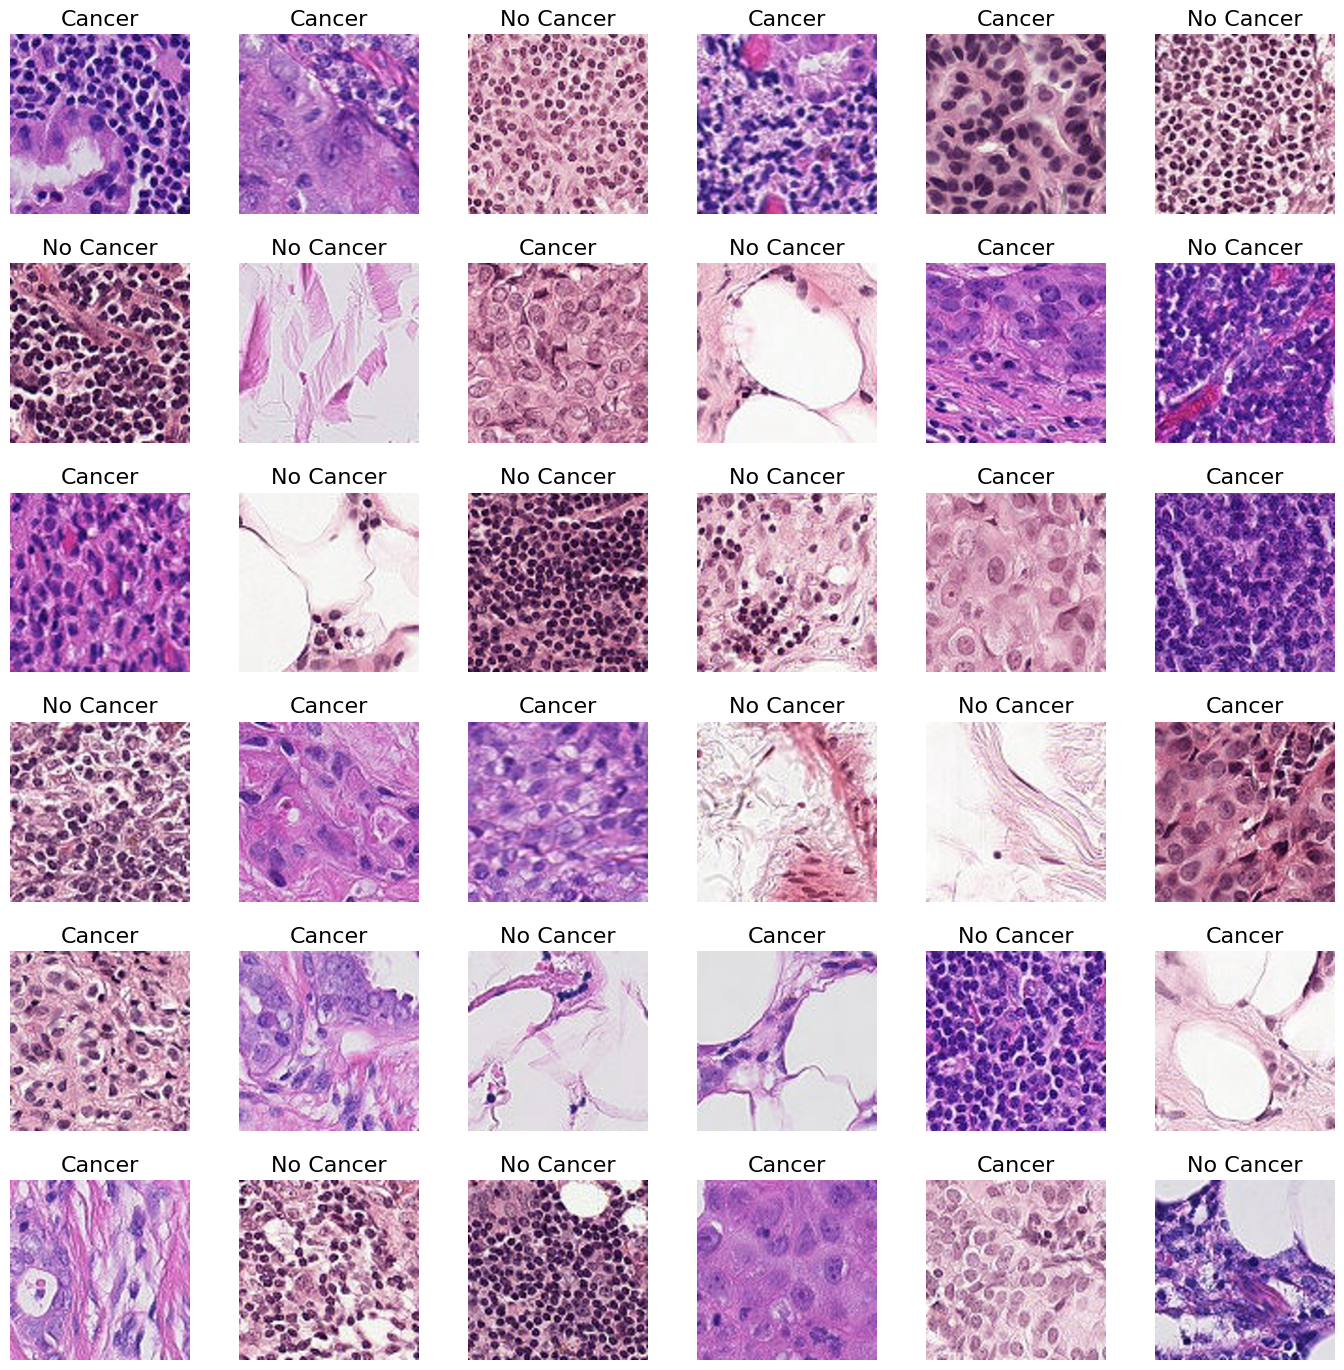

In [7]:
import numpy as np
from PIL import Image
import io

# Data visualization - Display a grid of images with labels
rows, cols = 6, 6  # Grid size for displaying images
label_converter = {0: 'No Cancer', 1: 'Cancer'}  # Dictionary to convert numerical labels to text

# Extract images and labels from the dataset
images = ds['train']['image']
image_labels = ds['train']['labels']

# Set up the figure for visualization
fig, axs = plt.subplots(rows, cols, figsize=(14, 14))
axs = axs.flatten()

# Loop through images and labels, displaying each in the grid
for img_dict, img_label, ax in zip(images, image_labels, axs):
    # Extract the image bytes from the dictionary
    img_data = img_dict.get('bytes', None)
    
    if img_data is None:
        print("No image data found in dictionary!")
        continue

    # Convert the bytes data to a PIL Image
    img = Image.open(io.BytesIO(img_data)).convert("RGB")
    
    # Convert to NumPy array for imshow
    img = np.array(img)

    # Display the image
    ax.imshow(img)
    ax.set_title(label_converter[img_label], fontsize=16)
    ax.axis('off')  # Hide axes for a cleaner look

# Adjust the layout to avoid overlapping
fig.tight_layout(pad=2.0)

# Show the figure
plt.show()


### Models and Inference

In [8]:
# Model building with EfficientNet
# Define transformations for training and evaluation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset to apply transformations
class HistopathologicCancerDataset(TorchDataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the image path directly
        image_path = self.dataset[idx]['image_path']
        
        # Load the image and ensure it's in the correct format
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations if they are provided
        if self.transform:
            image = self.transform(image)
        
        # Get the label
        label = self.dataset[idx]['labels']
        
        return image, label


In [9]:
# Create Datasets
train_dataset = HistopathologicCancerDataset(ds['train'], transform=transform)
eval_dataset = HistopathologicCancerDataset(ds['eval'], transform=transform)
test_dataset = HistopathologicCancerDataset(ds['test'], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

This code snippet is focused on preparing the dataset and defining a custom dataset class for use with PyTorch, specifically tailored for training an EfficientNet model for histopathologic cancer detection. 

 1. **Transformation pipeline**

```python
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
```

- **Purpose:** This block of code defines a series of transformations that will be applied to each image before it's fed into the model.
  - **`Resize((224, 224))`:** Resizes each image to 224x224 pixels, which is the input size expected by the EfficientNet model.
  - **`ToTensor()`:** Converts the image from a PIL Image (or NumPy array) to a PyTorch tensor. This is necessary because PyTorch models work with tensors.
  - **`Normalize(mean, std)`:** Normalizes the tensor image with the specified mean and standard deviation. The values `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` are the mean and standard deviation of the ImageNet dataset, which EfficientNet was pre-trained on. Normalization ensures that the input distribution matches what the model was trained on, which can improve performance.

2. **Custom Dataset Class**

```python
class HistopathologicCancerDataset(TorchDataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the image path directly
        image_path = self.dataset[idx]['image_path']
        
        # Load the image and ensure it's in the correct format
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations if they are provided
        if self.transform:
            image = self.transform(image)
        
        # Get the label
        label = self.dataset[idx]['labels']
        
        return image, label
```

- **Purpose:** This class is a custom PyTorch `Dataset` that allows you to apply transformations to your images and easily access them during model training.

**`__init__` Method:**
- **`dataset`:** This is the dataset passed to the class, containing both image paths and labels. It’s typically a Pandas DataFrame or a similar structure.
- **`transform`:** This is the transformation pipeline defined earlier. It will be applied to each image when it's accessed.

**`__len__` Method:**
- **Purpose:** This method returns the total number of samples in the dataset. This is important for PyTorch DataLoader to know how many batches to create.

**`__getitem__` Method:**
- **Purpose:** This method retrieves a single sample (an image and its corresponding label) from the dataset.
  - **`image_path = self.dataset[idx]['image_path']`:** Fetches the file path of the image at the given index `idx`.
  - **`image = Image.open(image_path).convert("RGB")`:** Opens the image file and converts it to RGB format. Even if the image is grayscale, this ensures that it has three channels, which is necessary for the model.
  - **`if self.transform: image = self.transform(image)`:** Applies the transformations (resize, tensor conversion, normalization) to the image if the `transform` pipeline is provided.
  - **`label = self.dataset[idx]['labels']`:** Retrieves the label corresponding to the image.
  - **`return image, label`:** Returns the transformed image and its label, which will be used by the model during training or evaluation.


In [10]:
# Load EfficientNet model architecture
model = models.efficientnet_b0(pretrained=False)

# Load the saved weights from the Kaggle dataset
model.load_state_dict(torch.load('/kaggle/input/efficientnet_b0/pytorch/default/1/efficientnet_b0_rwightman-7f5810bc.pth'))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

This code snippet is focused on loading an EfficientNet model, specifically the EfficientNet-B0 architecture, into your environment, loading pre-trained weights, and moving the model to a GPU if one is available. 

#### **Loading the EfficientNet model architecture**

```python
model = models.efficientnet_b0(pretrained=False)
```

- **`models.efficientnet_b0`:** This function from the `torchvision` library loads the EfficientNet-B0 architecture. EfficientNet is a family of convolutional neural networks known for their efficiency and strong performance on image classification tasks.
- **`pretrained=False`:** By setting `pretrained=False`, you're specifying that you do not want to load the default ImageNet pre-trained weights that come with the `torchvision` implementation. Instead, you'll be loading custom weights in the next step. If `pretrained=True` were used, it would load the ImageNet-pretrained weights by default.

#### **Loading pretrained weights**

```python
model.load_state_dict(torch.load('/kaggle/input/efficientnet_b0/pytorch/default/1/efficientnet_b0_rwightman-7f5810bc.pth'))
```

- **`model.load_state_dict(...)`:** This method loads the model parameters (weights) into the architecture you initialized earlier. The parameters are loaded from a file that contains the state dictionary.
- **`torch.load(...)`:** This function loads a saved model state from the specified file path. In this case, the file path is `/kaggle/input/efficientnet_b0/pytorch/default/1/efficientnet_b0_rwightman-7f5810bc.pth`.
  - **File Path:** This path points to the location where the custom pre-trained weights for EfficientNet-B0 are stored. These weights might be the result of further fine-tuning on a specific dataset (potentially for the histopathologic cancer detection task) rather than the general ImageNet weights.
  - **`efficientnet_b0_rwightman-7f5810bc.pth`:** This is the filename of the checkpoint containing the model weights.

#### **Moving the Model to GPU (if available)**

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
```

- **`torch.device(...)`:** This command checks if a GPU is available in your environment. If a GPU is detected (`cuda`), it assigns the model to run on the GPU. If no GPU is available, it defaults to running on the CPU (`cpu`).
- **`model.to(device)`:** This method moves the model's parameters to the specified device (either GPU or CPU). Running the model on a GPU (if available) accelerates the computation, especially when dealing with large datasets or complex models like EfficientNet.


In [11]:
# Modify the final layer for binary classification
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/5], Loss: 0.3427
Epoch [2/5], Loss: 0.1899
Epoch [3/5], Loss: 0.1232
Epoch [4/5], Loss: 0.0742
Epoch [5/5], Loss: 0.0544


This code focuses on preparing an EfficientNet model for binary classification, followed by the training process.

#### 1. **Final layer modification:**
The model's final classification layer is modified to output two classes (binary classification). This is achieved by replacing the existing fully connected layer with a new one that has an output size of 2.

#### 2. **Device assignment:**
The model is moved to a GPU if available, which speeds up the computation, especially useful when dealing with deep learning models like EfficientNet.

#### 3. **Loss function and optimizer:**
The loss function used is `CrossEntropyLoss`, which is standard for classification tasks as it measures the difference between the predicted and actual class distributions. The optimizer used is Adam (`optimizer = optim.Adam`), known for its efficiency in training deep neural networks, with a learning rate of `1e-4`.

#### 4. **Training loop:**
The training loop runs for 5 epochs. For each epoch:
- The model is set to training mode with `model.train()`.
- The data is processed in batches, where inputs and labels are moved to the GPU.
- The gradients are zeroed to prevent accumulation using `optimizer.zero_grad()`.
- The model makes predictions (`outputs`), calculates the loss, and backpropagates the error (`loss.backward()`).
- The optimizer updates the model's parameters to minimize the loss.
- The running loss for each epoch is calculated and printed, providing feedback on the model’s learning progress.

In [12]:
# Evaluate on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in eval_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

print('Finished Training')

Validation Accuracy: 93.10%
Finished Training


This code  evaluates the performance of the trained EfficientNet model on a validation dataset. The goal is to measure how well the model generalizes to new, unseen data, which is crucial for ensuring that the model is not overfitting to the training data.

#### 1. **Setting the model to evaluation mode:**
The first line, `model.eval()`, switches the model to evaluation mode. This is important because certain layers, like dropout and batch normalization, behave differently during training and evaluation. In evaluation mode, these layers are adjusted to ensure consistent and reliable predictions.

#### 2. **Disabling gradient calculation:**
The `with torch.no_grad():` block disables gradient computation. Since gradients are not needed during evaluation (because there is no backpropagation), this reduces memory usage and speeds up the computation. This is particularly beneficial when working with large models or datasets.

#### 3. **Looping through the validation data:**
The code then iterates over the batches of data in the validation loader (`eval_loader`). For each batch, the input data and corresponding labels are transferred to the device (GPU or CPU).

#### 4. **Model predictions:**
The model processes the inputs to generate outputs. These outputs are logits, representing the unnormalized log probabilities for each class. The `torch.max(outputs.data, 1)` function is used to find the class with the highest logit (i.e., the model's predicted class). The function returns both the maximum value and its index, but only the index (the predicted class) is needed here.

#### 5. **Accuracy calculation:**
The code then compares the model's predictions to the actual labels. It counts how many predictions are correct by summing up the number of times the predicted class matches the true label (`correct += (predicted == labels).sum().item()`). The total number of samples is also tracked (`total += labels.size(0)`).

#### 6. **Calculating and printing validation accuracy:**
After processing all the batches, the validation accuracy is calculated as the percentage of correct predictions out of the total number of samples (`100 * correct / total`). This accuracy is then printed to provide feedback on the model's performance on the validation set.

Finally, the script prints "Finished Training" to indicate that the evaluation process is complete.

A high validation accuracy, such as the 93.10% achieved in this example, suggests that the model is performing well on unseen data, indicating good generalization and effective training.

### Evaluation model

Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.96      0.96      0.96       624
      Cancer       0.93      0.94      0.93       376

    accuracy                           0.95      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.95      0.95      0.95      1000



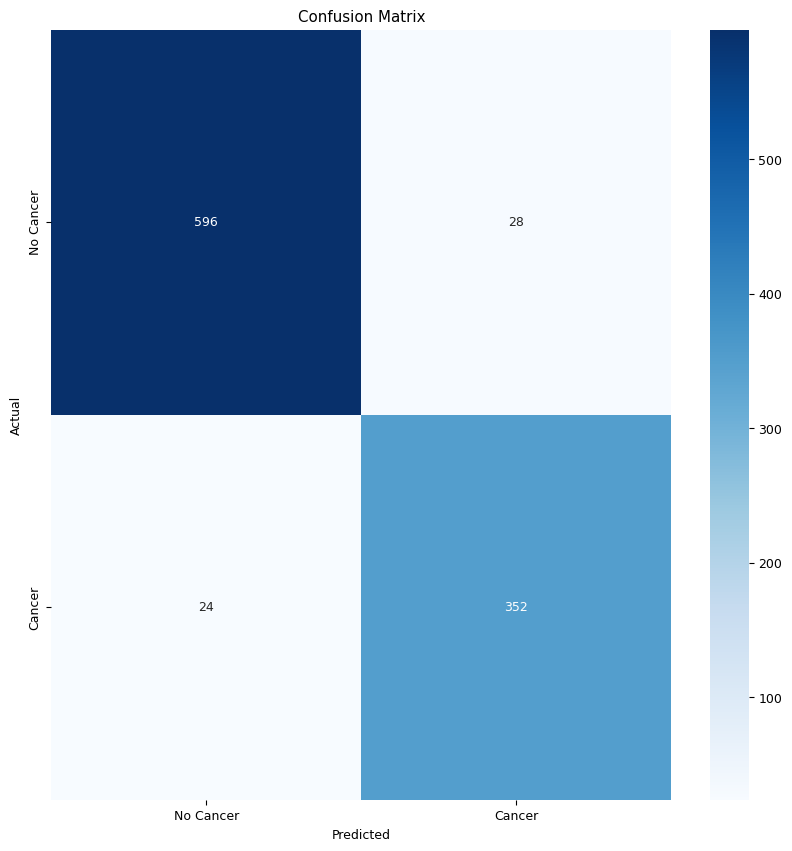

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Correct target names
target_names = ['No Cancer', 'Cancer']

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

- The confusion matrix shows that the model performs well, with high numbers of correct classifications (596 True Negatives and 352 True Positives) and relatively low misclassifications (28 False Positives and 24 False Negatives).
- Validation accuracy: The high accuracy and well-populated diagonal of the confusion matrix indicate that the model is effective at distinguishing between cancerous and non-cancerous images.
- Errors: Some misclassifications occur, but they are relatively few, suggesting that the model is robust but might benefit from further tuning or additional data to improve its performance even further.

In [14]:
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms

# Load the sample_submission.csv file
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

# Define the transformation applied to the test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the list for storing predictions
predictions = []

# Iterate over each image in the sample submission file
for index, row in sample_submission.iterrows():
    image_id = row['id']
    image_path = f"/kaggle/input/histopathologic-cancer-detection/test/{image_id}.tif"
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output.data, 1)
        predicted_label = predicted_label.item()
    
    # Append the prediction
    predictions.append(predicted_label)

# Add predictions to the sample submission DataFrame
sample_submission['label'] = predictions

# Save the submission file
sample_submission.to_csv('submission.csv', index=False)


### Final results

This code is designed to generate predictions for a set of test images and prepare a submission file for a Kaggle competition.

- The `sample_submission.csv` file is loaded, which contains the IDs of the test images that need predictions.
- A series of transformations is defined to resize each image to 224x224 pixels, convert it to a tensor, and normalize it based on the ImageNet dataset statistics. This is necessary because the EfficientNet model was originally trained on ImageNet, and using these statistics ensures consistency in input data.
- For each test image, the code:
     1. Loads the image using the ID provided in `sample_submission.csv`.
     2. Applies the preprocessing transformations.
     3. Passes the preprocessed image through the trained model to generate a prediction.
     4. The predicted class label (0 for "No Cancer", 1 for "Cancer") is extracted and appended to the `predictions` list.

- The predicted labels are added to the `sample_submission` DataFrame, and the modified DataFrame is saved as `submission.csv` for submission to Kaggle.
The model achieved a score of 0.8792 on the Kaggle leaderboard. This indicates a reasonably good performance but leaves room for improvement. 

### Improvements

1. **Data augmentation:** Applying data augmentation techniques could help the model generalize better by exposing it to a more diverse set of training images.
  
2. **Hyperparameter tuning:** Experimenting with different learning rates, optimizers, and batch sizes might further enhance performance.

3. **Model architecture:** Trying more advanced architectures or ensembling multiple models could boost accuracy.

4. **Handling class imbalance:** Implementing techniques to address class imbalance, such as oversampling the minority class, might improve the model's ability to detect cancerous images. 

By incorporating these improvements, the model’s performance on the test set could potentially increase, leading to a higher score in the competition.

In [15]:
from IPython.display import FileLink

# Provide a download link for the submission.csv file
FileLink(r'submission.csv')


/kaggle/working/submission.csv